<a href="https://colab.research.google.com/github/Neloxe/nlp-project/blob/main/RNN-Glove-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

In [13]:
# 1. CHARGEMENT DES DONNÉES
data = pd.read_csv('./train.csv', sep=',')
texts = data['comment_text'].astype(str).values
label_names = ['toxic', 'obscene', 'insult', 'identity_hate']
labels = data[label_names].values

In [14]:
# 2. TOKENISATION ET VECTORISATION
max_words = 20000  # Vocabulaire max
max_len = 100  # Longueur max des séquences
embedding_dim = 100  # Taille des embeddings

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [15]:
# 3. CHARGEMENT DES EMBEDDINGS PRÉ-ENTRAÎNÉS (ex: GloVe)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vectors

# Création de la matrice d'embedding
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

Mounted at /content/drive


In [16]:
# 4. SPLIT DES DONNÉES
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# 5. CONSTRUCTION DU MODÈLE
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='sigmoid')  # 6 classes multi-label (toxic, severe_toxic, obscene, etc.)
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │      22,134,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,134,300 (84.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 22,134,300 (84.44 MB)

In [17]:
# 6. ENTRAÎNEMENT DU MODÈLE
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.7148 - loss: 0.1406 - val_accuracy: 0.9941 - val_loss: 0.0757
Epoch 2/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.9714 - loss: 0.0766 - val_accuracy: 0.9941 - val_loss: 0.0698
Epoch 3/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.9666 - loss: 0.0710 - val_accuracy: 0.9941 - val_loss: 0.0679
Epoch 4/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 83s 25ms/step - accuracy: 0.9510 - loss: 0.0658 - val_accuracy: 0.9941 - val_loss: 0.0689
Epoch 5/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - accuracy: 0.9708 - loss: 0.0618 - val_accuracy: 0.9940 - val_loss: 0.0634
Epoch 6/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 83s 25ms/step - accuracy: 0.9788 - loss: 0.0570 - val_accuracy: 0.9941 - val_loss: 0.0670
Epoch 7/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.9810 - loss: 0.0547 - val_accuracy: 0.9936 - val_loss: 0.0644
Epoch 8/10
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.9838 -

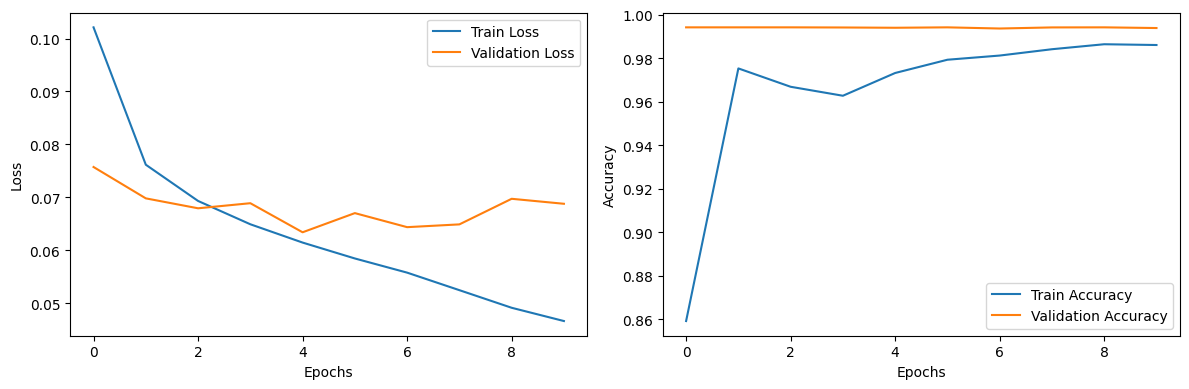

In [22]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# 7. PRÉDICTIONS ET ÉVALUATION
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


F1-Score for toxic: 0.7889
F1-Score for obscene: 0.7953
F1-Score for insult: 0.6998
F1-Score for identity_hate: 0.4306

F1-Score Macro (moyenne des classes): 0.6786


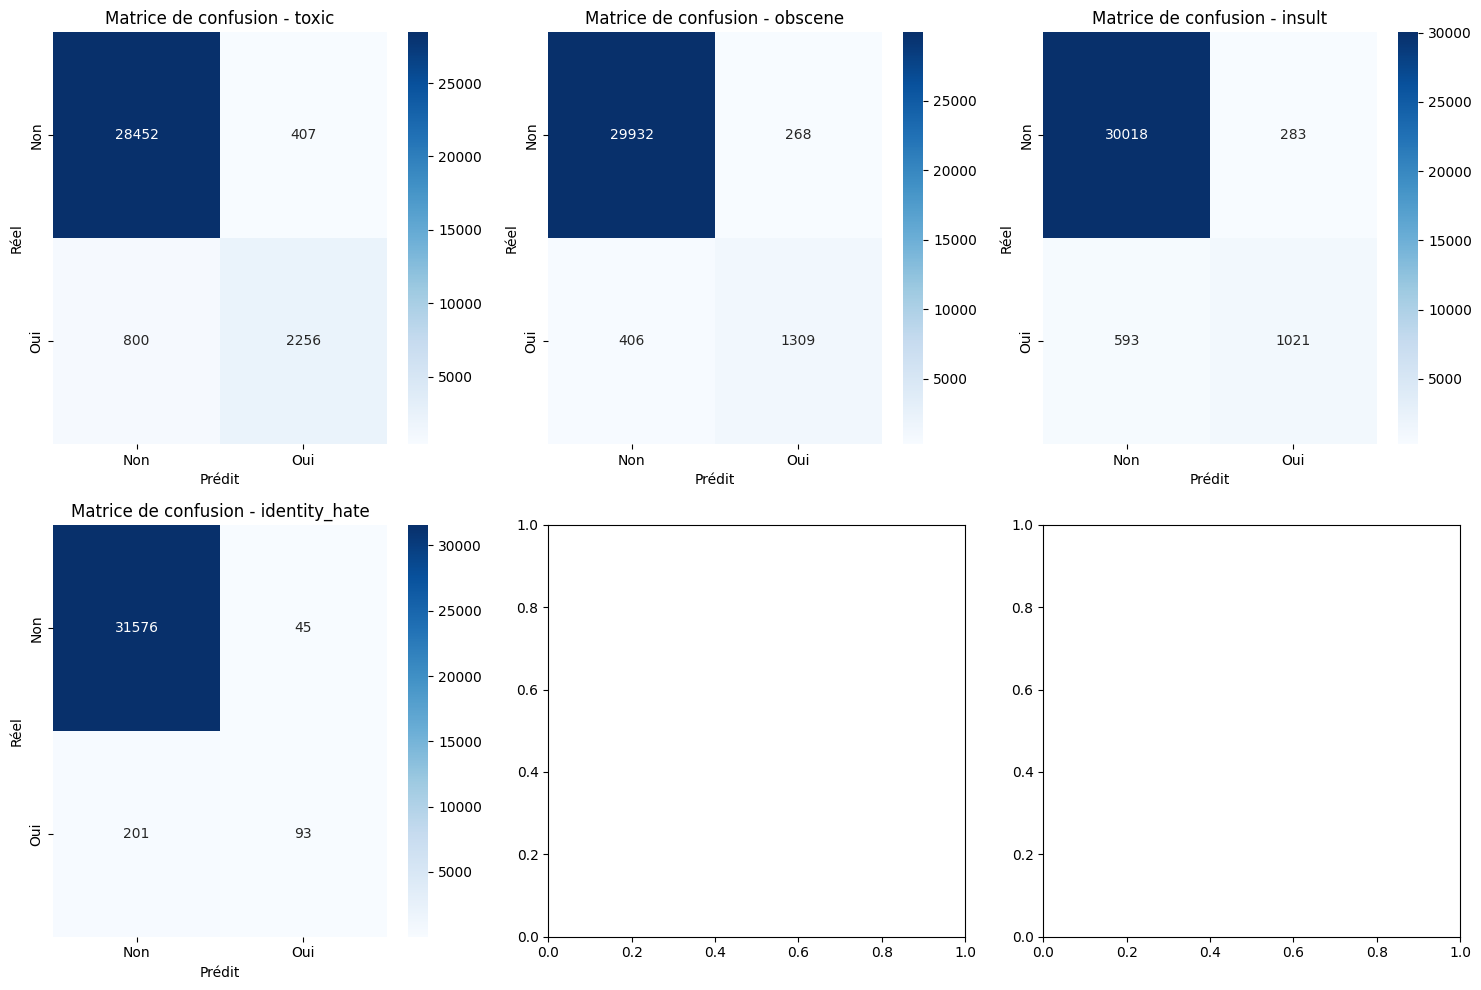

In [19]:
# F1-Score par classe
f1_scores = f1_score(y_test, y_pred, average=None)
for i, label in enumerate(label_names):
    print(f"F1-Score for {label}: {f1_scores[i]:.4f}")

# Score F1 global (moyenne macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"\nF1-Score Macro (moyenne des classes): {f1_macro:.4f}")

# 8. MATRICES DE CONFUSION
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(label_names):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non", "Oui"], yticklabels=["Non", "Oui"], ax=axes[i])
    axes[i].set_title(f"Matrice de confusion - {label}")
    axes[i].set_xlabel("Prédit")
    axes[i].set_ylabel("Réel")

plt.tight_layout()
plt.show()